<a href="https://colab.research.google.com/github/wahyuejunian/2D_Grav_matlab/blob/main/Grav2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

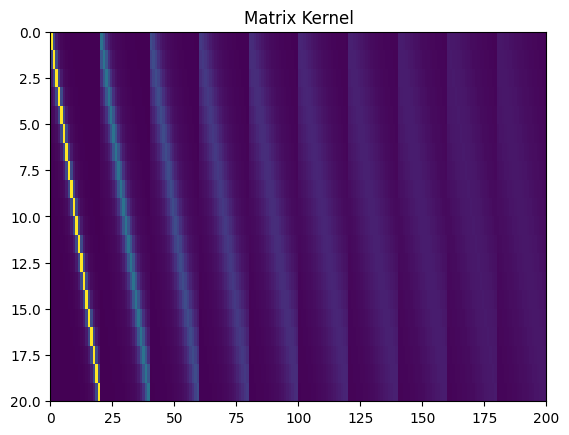

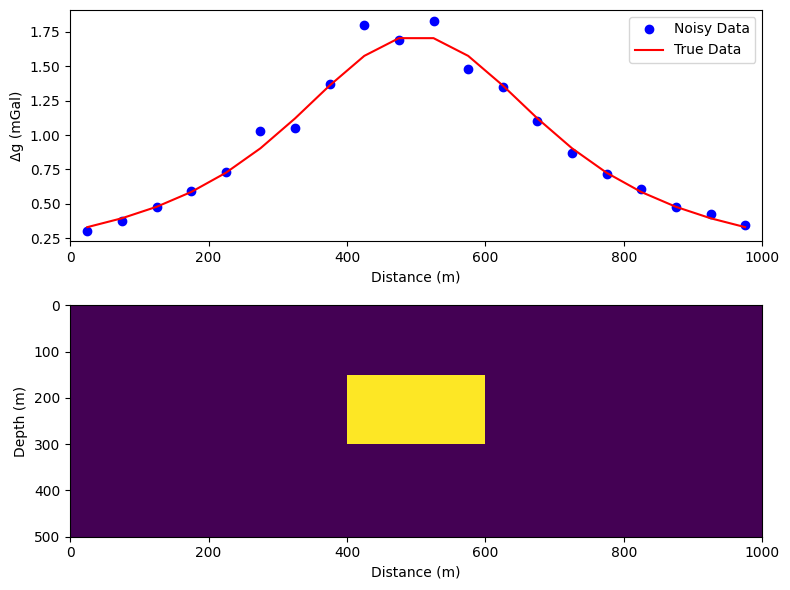

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def gpoly(x0, z0, xcorn, zcorn, ncorn):
    si2mg = 1e5  # SI to mGal
    km2m = 1e3   # km to m
    kG = 6.673e-11  # Gravity constant, N.m^2/kg^2

    sumG = 0
    for n in range(ncorn):
        n2 = 0 if n == ncorn - 1 else n + 1

        x1, z1 = xcorn[n] - x0, zcorn[n] - z0
        x2, z2 = xcorn[n2] - x0, zcorn[n2] - z0

        r1sq, r2sq = x1**2 + z1**2, x2**2 + z2**2

        if r1sq == 0 or r2sq == 0:
            raise ValueError("Field point on corner")

        denom = z2 - z1 if z2 - z1 != 0 else 1e-6

        alpha = (x2 - x1) / denom
        beta = (x1 * z2 - x2 * z1) / denom

        factor = beta / (1 + alpha**2)
        term1 = 0.5 * (np.log(r2sq) - np.log(r1sq))
        term2 = np.arctan2(z2, x2) - np.arctan2(z1, x1)

        sumG += factor * (term1 - alpha * term2)

    return 2 * kG * sumG * si2mg * km2m

# Constants
dx, dz = 50, 50
m = dx / 2
nx, nz = 20, 10
M = nx * nz
x = np.arange(1, nx + 1) * dx - m
N = len(x)

# Grid generation
xm, zm = np.meshgrid(np.arange(0, (nx + 1) * dx, dx), np.arange(0, (nz + 1) * dz, dz))

# Initial model (density)
rho = np.zeros((nz, nx))
# rho[1:8, 9:11] = 1  # Vertical model directly assigned
i_center = nz // 2
j_center = nx // 2
rho[3:6, 8:12] = 1  # Smaller tilted block
V = rho.reshape(-1, 1)

# Compute gravity effect
gz = np.zeros((N, nz, nx))
for n in range(N):
    for i in range(nz):
        for j in range(nx):
            xmm = [xm[i, j], xm[i, j + 1], xm[i + 1, j + 1], xm[i + 1, j]]
            zmm = [zm[i, j], zm[i, j + 1], zm[i + 1, j + 1], zm[i + 1, j]]
            gz[n, i, j] = gpoly(x[n], 0, xmm, zmm, 4)

# Kernel matrix
A = np.zeros((N, M))
k = 0
for i in range(nz):
    for j in range(nx):
        A[:, k] = gz[:, i, j]
        k += 1

# Forward Calculation
dGcal = A @ V

# Add Noise
noise = 0.05 * dGcal * np.random.randn(*dGcal.shape)
dGcal_noise = dGcal + noise

# Visualization
plt.figure()
plt.pcolormesh(A, shading='auto')
plt.gca().invert_yaxis()
plt.title('Matrix Kernel')
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(x, dGcal_noise, 'bo', markerfacecolor='b', label='Noisy Data')
plt.plot(x, dGcal, '-r', linewidth=1.5, label='True Data')
plt.xlabel('Distance (m)')
plt.ylabel('\u0394g (mGal)')
plt.legend()
plt.xlim([x.min()-m, x.max()+m])

plt.subplot(2, 1, 2)
plt.pcolormesh(xm, zm, rho, shading='auto', cmap='viridis')
# plt.colorbar(label='Density')
plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
